In [2]:
import numpy as np
import pandas as pd
from numpy.random import randn, normal, uniform
from statistics import mean, stdev
import h2o
import os
import time
import math
import matplotlib.pyplot as plt

from evaluation.helpers import mask, generate_LRGC
from em.low_rank_expectation_maximization import LowRankExpectationMaximization
from glrm.loss import QuadraticLoss
from glrm.reg import QuadraticReg
from glrm.glrm import GLRM
from glrm.convergence import Convergence
from glrm.util import pplot

In [26]:
from julia.api import Julia
jl = Julia(compiled_modules=False)

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
import pyglrm

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/ongrayyi/.local/lib/python3.8/site-packages/julia/core.py:687: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


In [3]:
# Init h2o
from h2o.estimators import H2OGeneralizedLowRankEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "13.0.1" 2019-10-15; Java(TM) SE Runtime Environment (build 13.0.1+9); Java HotSpot(TM) 64-Bit Server VM (build 13.0.1+9, mixed mode, sharing)
  Starting server from /Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1r/xbbm4brd1t5fjqmzh34nsv9w0000gn/T/tmphm6v94ge
  JVM stdout: /var/folders/1r/xbbm4brd1t5fjqmzh34nsv9w0000gn/T/tmphm6v94ge/h2o_ongrayyi_started_from_python.out
  JVM stderr: /var/folders/1r/xbbm4brd1t5fjqmzh34nsv9w0000gn/T/tmphm6v94ge/h2o_ongrayyi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,3 months and 23 days !!!
H2O_cluster_name:,H2O_from_python_ongrayyi_wce2v7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [4]:
# Function for calculating error

class NormalisedRMSErr():
    def __call__(self, A, A_hat, indices=None): 
        #Normalize by the standard deviation of each column
        mask = np.tile(np.std(A, axis=0), (len(A), 1))
        A_diff = np.divide((A - A_hat), mask)
        if indices is not None:
            A_diff_temp = []
            for i, j in indices:
                A_diff_temp.append(A_diff[i, j])
            A_diff = np.array(A_diff_temp)
        return math.sqrt(np.mean(np.square(A_diff)))

In [5]:
# Functions for generating continuous data

def generate_data(m, n, k, noise, noise_lvl, seed=1, orig=False):
    np.random.seed(seed)  
    A = randn(m,k).dot(randn(k,n))
    A_orig = A.copy()
    
    if noise == 'gaussian':
        noise_arr = np.zeros((m,n))
        for j in range(n):
            sigma_j = np.std(A[:, j])
            noise_arr[:, j] = normal(scale=sigma_j, size=m)
        A += noise_arr
        #A = A + normal(size=(m,n), scale=sigma_j*noise_lvl)
    elif noise == 'rndselect':
        sigma_A = np.std(A)
        for i in range(m):
            for j in range(n):
                if uniform() < noise_lvl:
                    A[i, j] = normal(scale=sigma_A)
                    
    if orig is False:
        return A
    else:
        return A, A_orig

In [28]:
# Function for doing experiments

def imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name, loss='quadratic', reg=0, mode='w'):
    # Compute average of errors for each rank
    
    #Log
    file_path = 'imputation_exp_outputs/'+ exp_name + '.txt'
    if os.path.exists(file_path):
          os.remove(file_path)
    
    k_list = []
    mean_errs = []
    std_dev_errs = []
    mean_times = []
    std_dev_times = []
    pred_err = NormalisedRMSErr()

    for k_model in k_exp_list:
        with open(file_path, 'a+') as file:
            file.write('----- RANK {} -----\n'.format(k_model))
        k_fixed_times = []
        k_fixed_errs = []
        for i in range(iterations):

            # Generate data
            A = generate_data(m, n, k, noise, noise_lvl, seed=i)
            A_masked, mask_indices, _ = mask(A, ratio, seed=i)
            if model_type == 'glrm_h2o':
                A_masked = pd.DataFrame(A_masked)
                for index in mask_indices:
                    A_masked.loc[index[0], index[1]] = 'missing'

            # Impute data
            start_time = time.time()
            if model_type == 'lrgc':
                model = LowRankExpectationMaximization()
                A_imp, _, _ = model.impute_missing(A_masked, k_model, verbose=True)
            elif model_type == 'glrm':
                if loss == 'quadratic':
                    mask_indices_split = [[tuple(index) for index in mask_indices]]
                    glrm_loss = [QuadraticLoss]
                    regX, regY = QuadraticReg(reg), QuadraticReg(reg)
                    converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10)
                    model = GLRM([A], glrm_loss, regX, regY, k_model, mask_indices_split, converge=converge, obj_type=1)
                    model.fit();
                    A_imp = model.predict()
            elif model_type == 'glrm_h2o':
                train = h2o.H2OFrame(A_masked, na_strings=['missing'])
                glrm_model = H2OGeneralizedLowRankEstimator(k=k_model,
                            loss=loss,
                            gamma_x=reg,
                            gamma_y=reg,
                            max_iterations=700,
                            recover_svd=True,
                            init="SVD")
                glrm_model.train(training_frame=train)
                A_imp = glrm_model.predict(train)
                A_imp = A_imp.as_data_frame().to_numpy()
            elif model_type == 'pyglrm':
                if loss == 'quadratic':
                    glrm_loss = pyglrm.QuadLoss()
                regX, regY = pyglrm.ZeroReg(), pyglrm.ZeroReg()
                model = pyglrm.glrm(glrm_loss, regX, regY, n_components=k_model, offset=True, scale=True)
                A_imp = model.fit_impute(A_masked)
            end_time = time.time()
            elapsed_time = end_time - start_time

            k_fixed_errs.append(pred_err(A, A_imp, indices=mask_indices))
            k_fixed_times.append(elapsed_time)

        k_list.append(k_model)
        mean_times.append(mean(k_fixed_times))
        std_dev_times.append(stdev(k_fixed_times))
        mean_errs.append(mean(k_fixed_errs))
        std_dev_errs.append(stdev(k_fixed_errs))
        with open(file_path, 'a+') as file:
            file.write('Mean Prediction Errors - ' + str(mean_errs[-1]) + '\n')
            file.write('Std Dev - ' + str(std_dev_errs[-1]) + '\n')
            file.write('Mean Time - ' + str(mean_times[-1]) + '\n')
            file.write('Std Time - ' + str(std_dev_times[-1]) + '\n')


    # Save data to dataframe for future use
    data = {
        "Rank" : k_list,
    }
    data['Mean Error'] = mean_errs
    data['Std Dev Error'] = std_dev_errs
    data['Mean Time'] = mean_times
    data['Std Dev Time'] = std_dev_times
    df = pd.DataFrame.from_dict(data)
    
    if mode == 'a':
        header = False
    elif mode == 'w':
        header = True
    df.to_csv('imputation_exp_outputs/'+ exp_name + '.csv', mode=mode, header=header)

# Typical Gaussian Noise

## Low missing low noise

In [29]:
# Create continuous data
m, n, k = 120, 60, 5
noise = 'gaussian'
noise_lvl = 0.1
ratio = 0.02
k_exp_list = [1, 3, 4, 5, 6, 7, 10]
iterations = 20

### Exp 1

In [26]:
model_type = 'glrm_h2o'
exp_name = 'lrgcvsglrm_cont/Exp_1_0.02ratio_gaussian_glrmh2o_0.1noise'

In [27]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name)

### Exp 2

In [140]:
model_type = 'lrgc'
exp_name = 'lrgcvsglrm_cont/Exp_2_0.02ratio_gaussian_lrgc_0.1noise'

In [141]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name)

### Exp 14

In [13]:
model_type = 'glrm'
exp_name = 'lrgcvsglrm_cont/Exp_14_0.02ratio_gaussian_glrm_0.1noise'

In [14]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name)

## High missing low noise

In [16]:
ratio = 0.4
noise_lvl = 0.1

### Exp 3

In [17]:
model_type = 'glrm_h2o'
exp_name = 'lrgcvsglrm_cont/Exp_3_0.4ratio_gaussian_glrmh2o_0.1noise'

In [18]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name)

### Exp 4

In [23]:
model_type = 'lrgc'
exp_name = 'lrgcvsglrm_cont/Exp_4_0.4ratio_gaussian_lrgc_0.1noise'

In [24]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name)

### Exp 15

In [15]:
model_type = 'glrm'
exp_name = 'lrgcvsglrm_cont/Exp_15_0.4ratio_gaussian_glrm_0.1noise'

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name)

## Low missing high noise

In [28]:
ratio = 0.02
noise_lvl = 0.4

### Exp 5

In [30]:
model_type = 'glrm_h2o'
exp_name = 'lrgcvsglrm_cont/Exp_5_0.02ratio_gaussian_glrmh2o_0.4noise'

In [31]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name)

### Exp 6

In [32]:
model_type = 'lrgc'
exp_name = 'lrgcvsglrm_cont/Exp_6_0.02ratio_gaussian_lrgc_0.4noise'

In [33]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name)

## Low noise, vary missing ratio

In [19]:
ratio = 0.1
noise_lvl = 0.1
k_exp_list = [5]

### Exp 10

In [87]:
model_type = 'glrm_h2o'
exp_name = 'lrgcvsglrm_cont/Exp_10_0.1ratio_gaussian_glrmh2o_0.1noise'

### Exp 11

In [89]:
model_type = 'lrgc'
exp_name = 'lrgcvsglrm_cont/Exp_11_0.1ratio_gaussian_lrgc_0.1noise'

### Exp 16

In [20]:
model_type = 'glrm'
exp_name = 'lrgcvsglrm_cont/Exp_16_0.1ratio_gaussian_glrm_0.1noise'

In [21]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name)

In [7]:
ratio = 0.6
noise_lvl = 0.1
k_exp_list = [1, 2, 3, 4]

### Exp 12

In [8]:
model_type = 'glrm_h2o'
exp_name = 'lrgcvsglrm_cont/Exp_12_0.6ratio_gaussian_glrmh2o_0.1noise'

In [9]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name, mode='a')

### Exp 13

In [94]:
model_type = 'lrgc'
exp_name = 'lrgcvsglrm_cont/Exp_13_0.6ratio_gaussian_lrgc_0.1noise'

In [95]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name)

### Exp 17

In [23]:
model_type = 'glrm'
exp_name = 'lrgcvsglrm_cont/Exp_17_0.6ratio_gaussian_glrm_0.1noise'

In [24]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name)

## Pyglrm

In [30]:
ratio = 0.02
noise_lvl = 0.1
k_exp_list = [5]

### Exp 20

In [31]:
model_type = 'pyglrm'
exp_name = 'lrgcvsglrm_cont/Exp_20_0.02ratio_gaussian_pyglrm_0.1noise'

### Exp 21

In [33]:
ratio = 0.1
model_type = 'pyglrm'
exp_name = 'lrgcvsglrm_cont/Exp_21_0.1ratio_gaussian_pyglrm_0.1noise'

### Exp 22

In [35]:
ratio = 0.4
model_type = 'pyglrm'
exp_name = 'lrgcvsglrm_cont/Exp_22_0.4ratio_gaussian_pyglrm_0.1noise'

### Exp 23

In [37]:
ratio = 0.6
model_type = 'pyglrm'
exp_name = 'lrgcvsglrm_cont/Exp_23_0.6ratio_gaussian_pyglrm_0.1noise'

In [38]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name)

# Plot LRGC vs GLRM vs PyGLRM for low gaussian noise

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


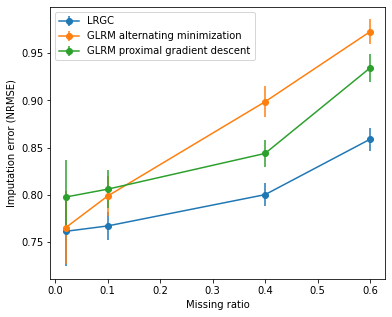

In [45]:
plt.figure(figsize=(6, 5))
ratios = [0.02, 0.1, 0.4, 0.6]
lrgc_mean_errs = [0.7611724750858422, 0.7668926999717526, 0.8000576311121136, 0.8587669919890119]
lrgc_std_errs = [0.037211445402654475, 0.014947617648857065, 0.011824740652758282, 0.011983489066956772]
pyglrm_mean_errs = [0.7975146033830023, 0.8058493077237765, 0.8437371832118298, 0.9342874620317886]
pyglrm_std_errs = [0.039334759426991356, 0.0200002481395134, 0.014357001737928346, 0.014890174526498138]
glrm_mean_errs = [0.765093284481215, 0.798572403391943, 0.8985175573744681, 0.9727259702090234]
glrm_std_errs = [0.03842150355102641, 0.021323483167918836, 0.016638673699344478, 0.013085095079411023]
plt.errorbar(ratios, lrgc_mean_errs, yerr=lrgc_std_errs,  label='LRGC', marker='o')
plt.errorbar(ratios, glrm_mean_errs, yerr=glrm_std_errs, label='GLRM alternating minimization', marker='o')
plt.errorbar(ratios, pyglrm_mean_errs, yerr=pyglrm_std_errs, label='GLRM proximal gradient descent', marker='o')
plt.xlabel('Missing ratio')
plt.ylabel('Imputation error (NRMSE)')
plt.legend()
#plt.show()
plt.savefig('imputation_exp_outputs/lrgcvsglrm_cont/3_methods_comparison.pdf')

# Random select noise

In [13]:
# Create continuous data
m, n, k = 120, 60, 5
noise = 'rndselect'
noise_lvl = 0.2
ratio = 0.3
k_exp_list = [5]
iterations = 20

## LRGC

In [14]:
model_type = 'lrgc'
exp_name = 'rndselect/0.3ratio_lrgc_0.2noise'

In [17]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name)

## GLRM Alt Min

In [24]:
model_type = 'glrm'
exp_name = 'rndselect/0.3ratio_glrm_0.2noise'

In [25]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name)

## GLRM quadratic

In [18]:
model_type = 'glrm_h2o'
exp_name = 'rndselect/0.3ratio_glrmh2o_quadratic_0.2noise'

In [19]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name)

## GLRM huber

In [22]:
model_type = 'glrm_h2o'
loss = 'huber'
exp_name = 'rndselect/0.3ratio_glrmh2o_huber_0.2noise'

In [23]:
%%capture
imputation_exp(m, n, k, noise, noise_lvl, ratio, k_exp_list, model_type, iterations, exp_name, loss=loss)

# Display imputation graphically to understand results

## GLRM

### 0.4 Missing

In [13]:
m=120
n=60
k=5
noise='gaussian'
noise_lvl=0.1
ratio=0.4
reg=0
seed=0
A, A_orig = generate_data(m, n, k, noise, noise_lvl, seed=0, orig=True)
A_masked, mask_indices, _ = mask(A, ratio, seed=0)

In [14]:
%%capture
k_model=5
mask_indices_split = [[tuple(index) for index in mask_indices]]
loss = [QuadraticLoss]
regX, regY = QuadraticReg(reg), QuadraticReg(reg)
converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10)
model = GLRM([A], loss, regX, regY, k_model, mask_indices_split, converge=converge, obj_type=1)
model.fit();
A_imp = model.predict()

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


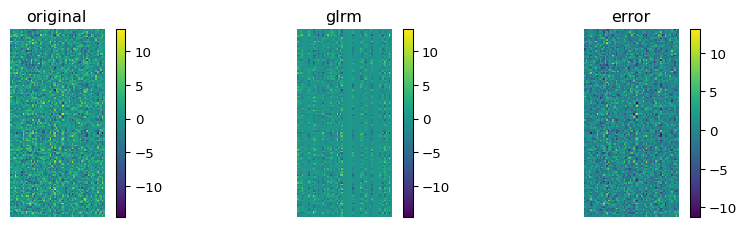

In [15]:
pplot([A, A_imp, A - A_imp], ["original", "glrm", "error"])

No handles with labels found to put in legend.


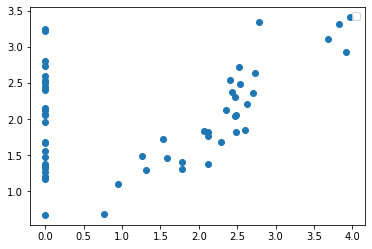

In [27]:
stds_imp = np.zeros(n)
#stds_original = np.zeros(n)
for j in range(n):
    std_i = np.std(A_imp[:,j])
    #std_o = np.std(A_imp[])
    stds_imp[j] = std_i
    
errors = [[] for i in range(n)]
for index in mask_indices:
    i, j = index[0], index[1]
    errors[j].append((A[i, j] - A_orig[i, j])**2)
errors = [math.sqrt(mean(e)) for e in errors]
    
missing_list = np.zeros(n)
for index in mask_indices:
    missing_list[index[1]] += 1

#stds_imp = [(float(i) - mean(stds_imp))/(max(stds_imp) - min(stds_imp)) for i in stds_imp]
#missing_list = [-(float(i) - mean(missing_list))/(max(missing_list) - min(missing_list)) for i in missing_list]
#errors = [(float(i) - mean(errors))/(max(errors) - min(errors)) for i in errors]
#plt.plot(stds_imp, label='std')
#plt.plot(missing_list, label='missing')
#plt.plot(errors, label='errors')
plt.scatter(stds_imp, errors)
#plt.scatter(stds_imp, missing_list)
plt.legend()
plt.show()

### 0.02 Missing

In [41]:
m=120
n=60
k=5
noise='gaussian'
noise_lvl=0.1
ratio=0.02
reg=0
seed=0
A = generate_data(m, n, k, noise, noise_lvl, seed=0)
A_masked, mask_indices, _ = mask(A, ratio, seed=0)

In [42]:
%%capture
k_model=5
mask_indices_split = [[tuple(index) for index in mask_indices]]
loss = [QuadraticLoss]
regX, regY = QuadraticReg(reg), QuadraticReg(reg)
converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10)
model = GLRM([A], loss, regX, regY, k_model, mask_indices_split, converge=converge, obj_type=1)
model.fit();
A_imp = model.predict()

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


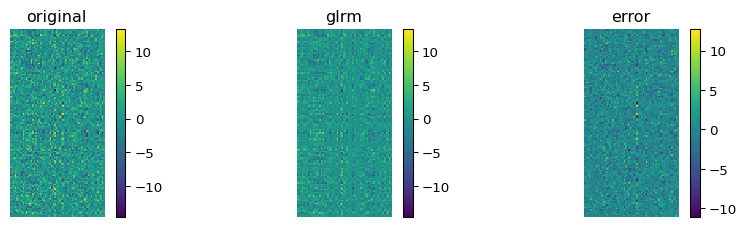

In [43]:
pplot([A, A_imp, A - A_imp], ["original", "glrm", "error"])

## GLRM h2o

In [12]:
m=120
n=60
k=5
noise='gaussian'
noise_lvl=0.1
ratio=0.4
reg=0
seed=0
A = generate_data(m, n, k, noise, noise_lvl, seed=0)
A_masked, mask_indices, _ = mask(A, ratio, seed=0)

In [45]:
train = h2o.H2OFrame(A_masked, na_strings=['missing'])
glrm_model = H2OGeneralizedLowRankEstimator(k=k_model,
            loss='quadratic',
            gamma_x=reg,
            gamma_y=reg,
            max_iterations=700,
            recover_svd=True,
            init="SVD")
glrm_model.train(training_frame=train)
A_imp = glrm_model.predict(train)
A_imp = A_imp.as_data_frame().to_numpy()

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/requests/cookies.py:521: ResourceWarning: unclosed file <_io.FileIO name='/var/folders/1r/xbbm4brd1t5fjqmzh34nsv9w0000gn/T/tmpbu0tgx03.csv' mode='rb' closefd=True>
  names_from_jar = [cookie.name for cookie in cookiejar]


Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%


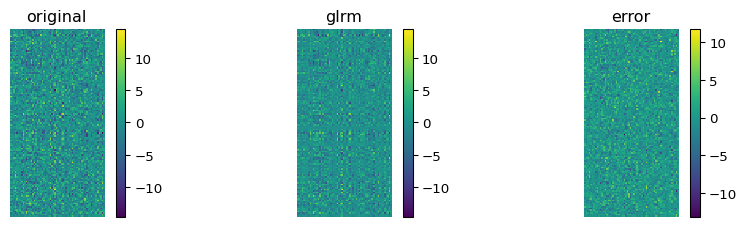

In [46]:
pplot([A, A_imp, A - A_imp], ["original", "glrm", "error"])

# Aside to debug

In [77]:
A = generate_data(m, n, k, noise, noise_lvl, seed=0)
A_masked, mask_indices, _ = mask(A, ratio, seed=0)
A_masked = pd.DataFrame(A_masked)
cols = A_masked.columns
for i, index in enumerate(mask_indices):
    if i == 1:
        print(index)
    A_masked.loc[index[0], index[1]] = 'missing'

[45  7]


In [81]:
train = h2o.H2OFrame(A_masked, na_strings=['missing'])
glrm_model = H2OGeneralizedLowRankEstimator(k=5,
            loss='quadratic',
            gamma_x=0,
            gamma_y=0,
            max_iterations=700,
            recover_svd=True,
            init="SVD")
glrm_model.train(training_frame=train)
A_imp = glrm_model.predict(train)
A_imp = A_imp.as_data_frame().to_numpy()

Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%


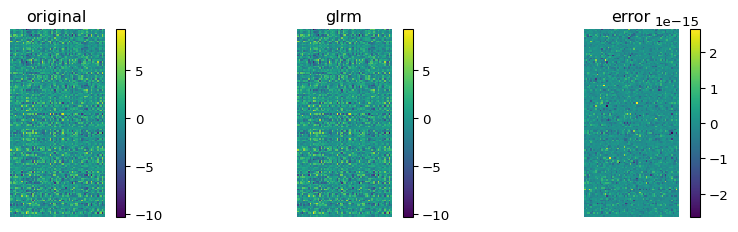

In [83]:
pplot([A, A_imp, A-A_imp], ["original", "glrm", "error"])

# Aside to discover why original GLRM cannot work properly

In [129]:
A = generate_data(m, n, k, noise, noise_lvl, seed=0)
A_masked, mask_indices, _ = mask(A, ratio, seed=0)
mask_indices_split = [[tuple(index) for index in mask_indices]]
loss = [QuadraticLoss]
regX, regY = QuadraticReg(0.01), QuadraticReg(0.01)
converge = Convergence(TOL = 1e-4, max_iters = 1000, max_buffer=10)
model = GLRM([A], loss, regX, regY, 5, mask_indices_split, converge=converge, obj_type=1)
model.fit();
A_imp = model.predict()

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/GLRM-0.0.1-py3.8.egg/glrm/glrm.py:216: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A = hstack(bi for bi in B)
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has 

---------- ITERATION 0 ----------


/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Residual norm for X minimization: 56.78303321204
Residual norm for Y minimization: 15.133932968058843
---------- ITERATION 1 ----------
Residual norm for X minimization: 17.806771195992955
Residual norm for Y minimization: 15.20732188819773
---------- ITERATION 2 ----------
Residual norm for X minimization: 17.575686100150346
Residual norm for Y minimization: 4.945058032530131
---------- ITERATION 3 ----------
Residual norm for X minimization: 16.58542892782078
Residual norm for Y minimization: 16.358436041606186
---------- ITERATION 4 ----------
Residual norm for X minimization: 16.473612118196872
Residual norm for Y minimization: 16.476643495383712
---------- ITERATION 5 ----------
Residual norm for X minimization: 16.36927449589797
Residual norm for Y minimization: 4.115582592930922
---------- ITERATION 6 ----------
Residual norm for X minimization: 15.510510388361599
Residual norm for Y minimization: 17.652838084050217
---------- ITERATION 7 ----------
Residual norm for X minimizat

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


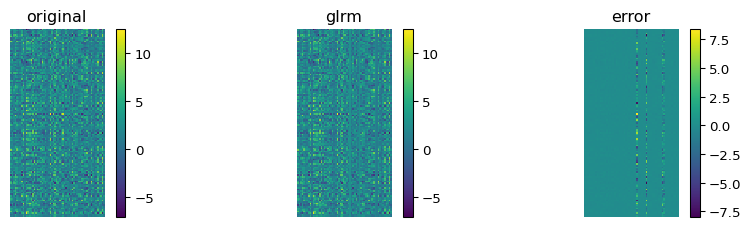

In [130]:
pplot([A, A_imp, A - A_imp], ["original", "glrm", "error"])

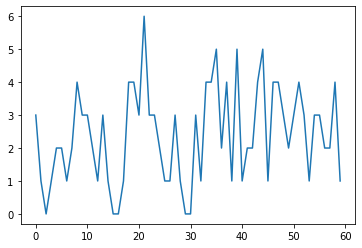

In [125]:
missing_list = np.zeros(n)
for index in mask_indices:
    missing_list[index[1]] += 1
    
plt.plot(missing_list)
plt.show()

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


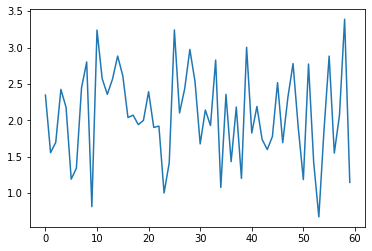

In [126]:
stds = np.zeros(n)
for j in range(n):
    std = np.std(A[:,j])
    stds[j] = std
plt.plot(stds)
plt.show()

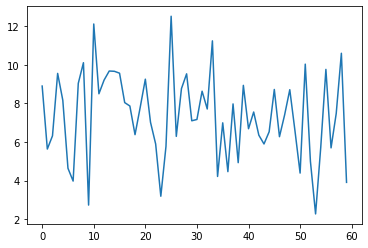

In [131]:
largest = np.zeros(n)
for j in range(n):
    big = max(np.absolute(A[:,j]))
    largest[j] = big
plt.plot(largest)
plt.show()